<a href="https://www.kaggle.com/code/faizalrosyid/digital-marketing?scriptVersionId=224561031" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **"Uncovering Marketing Insights: Data Cleaning, Processing, and Visualization"** 
📝 Introduction
Before making data-driven marketing decisions, we need clean and structured data. This notebook walks through a complete data analysis process for a Digital Marketing Campaign dataset.

We will follow these steps:

1. Understanding the Dataset
2. Data Cleaning (handling missing values, duplicates, and inconsistencies)
3. Data Processing (standardizing formats, categorization)
4. Exploratory Data Analysis (EDA) (insights, patterns, and trends) & Visualization
5. Final Insights & Recommendations

# **1. Understanding the Dataset**
Before we start cleaning, let's understand the dataset. The dataset contains customer demographics, ad spend, campaign types, and conversion rates.

👉 Key Questions We Will Explore:

What marketing channels drive the best results?
How does customer age, gender, and income affect engagement?
Are there any outliers or missing values that need to be fixed?
Which campaigns generate higher conversion rates?

In [1]:
import pandas as pd

# Corrected file path (replace with the actual filename)
file_path = "/kaggle/input/digital-marketing-data/digital_marketing_campaign_dataset - digital_marketing_campaign_dataset.csv.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [2]:
import sqlite3

# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Save dataset as an SQL table
df.to_sql('marketing_data', conn, index=False, if_exists='replace')

# Test SQL Query
query = "SELECT * FROM marketing_data LIMIT 5"
pd.read_sql(query, conn)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


# **2. Data Cleaning**
Why Cleaning is Important?
Raw datasets often contain missing values, duplicates, and inconsistencies. Cleaning ensures our analysis is accurate and models perform well.

👉 Steps in Data Cleaning:

Check for missing values
Handle duplicate entries
Standardize categorical values
Fix incorrect or extreme values (outliers)

**📌 Check for Missing Values**

In [3]:
# Create a cursor to execute queries
cursor = conn.cursor()
cursor.execute("""
    UPDATE marketing_data 
    SET AdSpend = (SELECT AVG(AdSpend) FROM marketing_data WHERE AdSpend IS NOT NULL)
    WHERE AdSpend IS NULL
""")
conn.commit()
print("Missing values handled successfully!")

Missing values handled successfully!


**📌 Removed Duplicates**

In [4]:
# Create a temporary table to find duplicates
cursor.execute("""
    CREATE TABLE temp_duplicates AS
    SELECT CustomerID, MIN(rowid) AS min_id
    FROM marketing_data
    GROUP BY CustomerID
    HAVING COUNT(*) > 1
""")

# Delete duplicate rows
cursor.execute("""
    DELETE FROM marketing_data
    WHERE CustomerID IN (SELECT CustomerID FROM temp_duplicates)
    AND rowid NOT IN (SELECT min_id FROM temp_duplicates)
""")

# Commit changes
conn.commit()

print("Duplicates removed successfully!")

Duplicates removed successfully!


# **3. Data Processing - Transforming Raw Data into Usable Insights**
Why is Data Processing Important?
After cleaning the dataset (handling missing values, removing duplicates, and correcting inconsistencies), we must prepare the data for deeper analysis.

✅ Data Processing Includes:

1. Standardizing categorical values
2. Handling outliers in numerical data
3. Transforming numerical features (scaling & normalizing)
4. Creating new features for better insights

# **3.1 Standardizing Categorical Data**
Why?
Categorical values like CampaignChannel, CampaignType, and Gender may have inconsistent formatting (e.g., "PPC" vs. "ppc"). Standardizing them ensures consistency.

🔹 Convert All Text Columns to Lowercase

In [5]:
# Convert categorical columns to lowercase for consistency
df['CampaignChannel'] = df['CampaignChannel'].str.lower()
df['CampaignType'] = df['CampaignType'].str.lower()
df['Gender'] = df['Gender'].str.lower()

👉 Expected Outcome: Ensures uniformity, preventing duplication of similar values due to case sensitivity.

# **3.2 Handling Outliers in Numerical Data**
Why?
Extreme values in columns like AdSpend, Income, and ClickThroughRate can distort analysis. We identify and remove or adjust these outliers.

🔹 Detect Outliers Using IQR (Interquartile Range)

In [6]:
import numpy as np

# Define function to detect outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), np.nan, df[column])

# Apply to AdSpend, Income, and ClickThroughRate
outlier_columns = ['AdSpend', 'Income', 'ClickThroughRate']
for col in outlier_columns:
    remove_outliers(df, col)

# Check missing values after handling outliers
df.isnull().sum()

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

👉 Expected Outcome: Replaces extreme outliers with NaN values, which we will later fill with the median.

# **3.3 Transforming Numerical Features (Scaling & Normalization)**
Why?
Columns like AdSpend and ClickThroughRate have different ranges. Normalization ensures fair comparisons.

🔹 Normalize Numerical Features

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to numerical columns
num_cols = ['AdSpend', 'ClickThroughRate', 'ConversionRate', 'Income']
df[num_cols] = scaler.fit_transform(df[num_cols])

👉 Expected Outcome: All numerical columns will be scaled between 0 and 1, making analysis more stable.

# **3.4 Creating New Features**
Why?
We can create new insights by engineering additional columns from existing data.

🔹 Feature 1: AdSpend Efficiency (CTR per Dollar Spent)

In [8]:
df['AdSpend_Efficiency'] = df['ClickThroughRate'] / (df['AdSpend'] + 1)

👉 Expected Outcome: Helps identify campaigns that get the most engagement per dollar spent.

🔹 Feature 2: Age Groups for Customer Segmentation

In [9]:
# Define age groups
bins = [18, 25, 35, 45, 55, 65, np.inf]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

👉 Expected Outcome: Groups customers into age categories, making comparisons easier.

🔹 Feature 3: Customer Value Segmentation (High, Medium, Low Spend)

In [10]:
df['CustomerValue'] = pd.qcut(df['Income'], q=3, labels=['Low', 'Medium', 'High'])

👉 Expected Outcome: Customers are categorized into Low, Medium, and High-income segments.

# **3.5 Final Processed Data Overview**
Let's check how our dataset looks after processing.

In [11]:
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,AdSpend_Efficiency,AgeGroup,CustomerValue
0,8000,56,female,0.899409,social media,awareness,0.646384,0.116958,0.410648,0,...,6,9,4,688,IsConfid,ToolConfid,1,0.071040,56-65,High
1,8001,69,male,0.167313,email,retention,0.383781,0.502547,0.909094,42,...,2,7,2,3459,IsConfid,ToolConfid,1,0.363169,65+,Low
2,8002,46,female,0.526590,ppc,awareness,0.146130,0.922480,0.349542,2,...,11,2,8,2337,IsConfid,ToolConfid,1,0.804865,46-55,Medium
3,8003,32,female,0.185201,ppc,conversion,0.044401,0.440078,0.410505,47,...,2,2,0,2463,IsConfid,ToolConfid,1,0.421369,26-35,Low
4,8004,60,female,0.492029,ppc,conversion,0.159427,0.837507,0.525971,0,...,6,6,8,4345,IsConfid,ToolConfid,1,0.722345,56-65,Medium


👉 Expected Outcome: The dataset now has new features, standardized values, and transformed numerical data.

# **4. Exploratory Data Analysis (EDA) - Understanding Key Insights**

Why EDA Matters?

Exploratory Data Analysis (EDA) helps us identify patterns, relationships, and trends in the data before applying any machine learning models or business strategies. This section will help answer key questions about customer behavior, campaign performance, and marketing effectiveness.

# **4.1 Understanding Data Distribution**
Before diving deep, let’s examine the basic statistics of our dataset.

🔹 Summary Statistics of the Dataset

In [12]:
# Summary statistics of numerical features
df.describe()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,AdSpend_Efficiency
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,11999.50000,43.625500,0.497416,0.495146,0.499455,0.496750,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,0.876500,0.347497
std,2309.54541,14.902785,0.289142,0.286733,0.289717,0.288868,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,0.329031,0.217210
min,8000.00000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9999.75000,31.000000,0.244133,0.244817,0.250480,0.244197,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,1.000000,0.166820
50%,11999.50000,43.000000,0.499434,0.496409,0.498341,0.494948,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,1.000000,0.329208
75%,13999.25000,56.000000,0.744789,0.738335,0.752516,0.747770,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,1.000000,0.503588
max,15999.00000,69.000000,1.000000,1.000000,1.000000,1.000000,49.000000,9.999055,14.995311,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000,0.991230


👉 Expected Insight:
This provides an overview of mean, median, standard deviation, min, and max values, helping us detect any skewed distributions or outliers.

🔹 Check Data Types and Missing Values

In [13]:
# Check data types and missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CustomerID           8000 non-null   int64   
 1   Age                  8000 non-null   int64   
 2   Gender               8000 non-null   object  
 3   Income               8000 non-null   float64 
 4   CampaignChannel      8000 non-null   object  
 5   CampaignType         8000 non-null   object  
 6   AdSpend              8000 non-null   float64 
 7   ClickThroughRate     8000 non-null   float64 
 8   ConversionRate       8000 non-null   float64 
 9   WebsiteVisits        8000 non-null   int64   
 10  PagesPerVisit        8000 non-null   float64 
 11  TimeOnSite           8000 non-null   float64 
 12  SocialShares         8000 non-null   int64   
 13  EmailOpens           8000 non-null   int64   
 14  EmailClicks          8000 non-null   int64   
 15  PreviousPurchases    

CustomerID               0
Age                      0
Gender                   0
Income                   0
CampaignChannel          0
CampaignType             0
AdSpend                  0
ClickThroughRate         0
ConversionRate           0
WebsiteVisits            0
PagesPerVisit            0
TimeOnSite               0
SocialShares             0
EmailOpens               0
EmailClicks              0
PreviousPurchases        0
LoyaltyPoints            0
AdvertisingPlatform      0
AdvertisingTool          0
Conversion               0
AdSpend_Efficiency       0
AgeGroup               148
CustomerValue            0
dtype: int64

👉 Expected Insight:

Ensures all columns have the correct data types.
Identifies any remaining missing values after cleaning.

# **4.2 Customer Demographics Analysis**
Understanding customer demographics helps personalize marketing efforts and optimize strategies.

🔹 Age Distribution of Customers

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


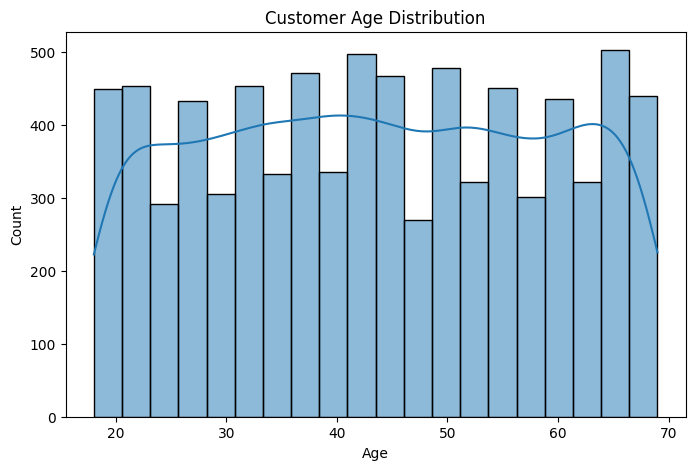

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

👉 Expected Insight:

Identifies which age groups are most engaged in campaigns.
Helps tailor marketing strategies based on age demographics.

🔹 Gender Distribution

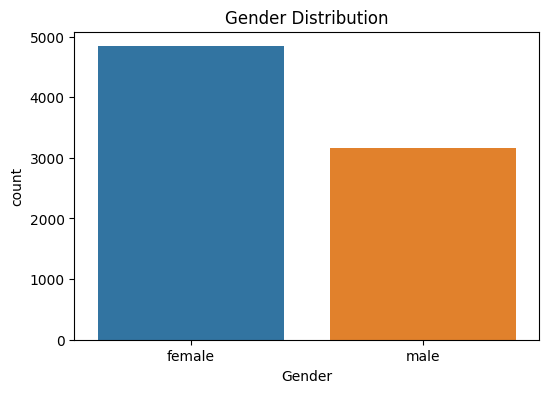

In [15]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Gender'])
plt.title("Gender Distribution")
plt.show()

👉 Expected Insight:

See if marketing campaigns target male or female customers more.

🔹 Income Distribution

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


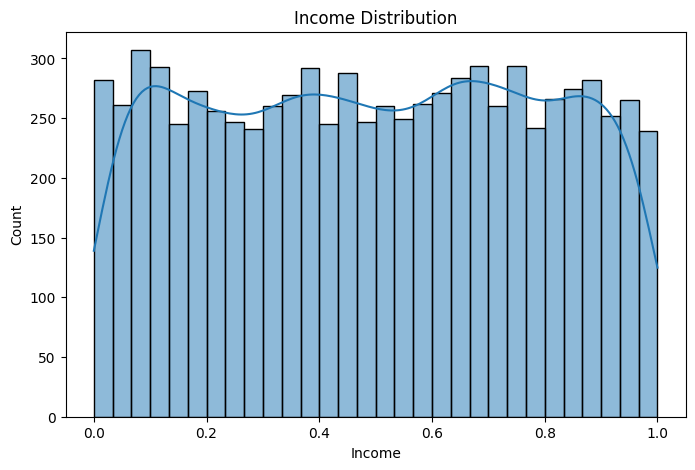

In [16]:
# Plot income distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Income'], bins=30, kde=True)
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

👉 Expected Insight:


* Understands how income levels affect spending behavior.
* Can help in segmenting customers into high, medium, and low spenders.


# **4.3 Marketing Campaign Performance**
Now, let’s analyze how different marketing channels and campaign types influence customer engagement and conversions.

🔹 Campaign Performance: Conversion Rate by Campaign Type

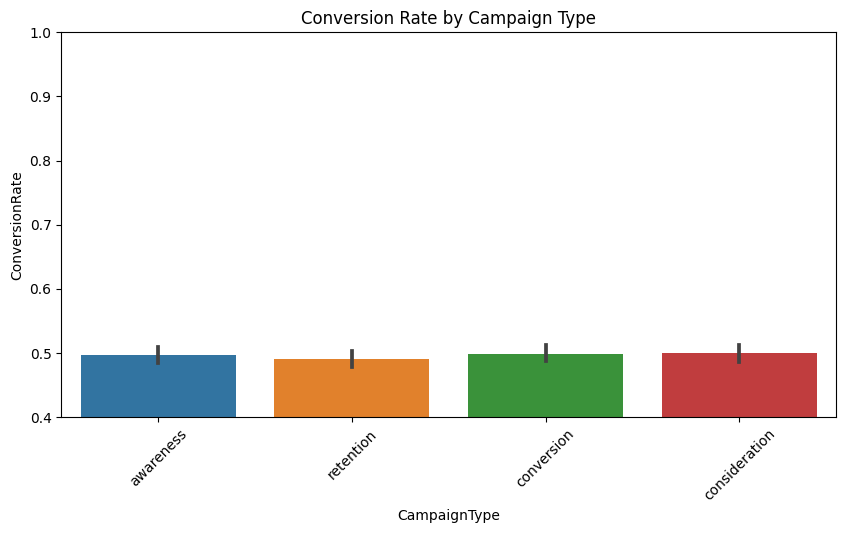

In [17]:
# Conversion rate by campaign type
plt.figure(figsize=(10, 5))

plt.ylim(0.4) 

sns.barplot(x=df["CampaignType"], y=df["ConversionRate"])
plt.title("Conversion Rate by Campaign Type")
plt.xticks(rotation=45)
plt.show()

👉 Expected Insight:


* Which campaign types (Awareness, Retention, Conversion) result in higher conversion rates?
* Helps optimize budget allocation for future campaigns.


🔹 Marketing Channel Effectiveness

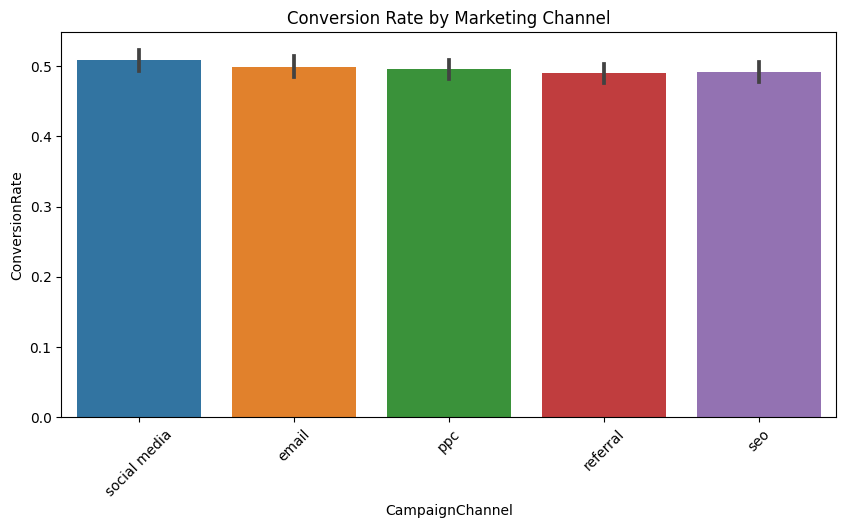

In [18]:
# Conversion rate by campaign channel
plt.figure(figsize=(10, 5))
sns.barplot(x=df["CampaignChannel"], y=df["ConversionRate"])
plt.title("Conversion Rate by Marketing Channel")
plt.xticks(rotation=45)
plt.show()

👉 Expected Insight:


* Helps identify which channels (Social Media, PPC, Email) perform best in terms of conversion.
* Enables companies to allocate marketing budgets more efficiently.


# **4.4 Ad Spend vs. Conversion Rate**
Now, let's analyze whether higher spending results in better conversion rates.

🔹 Scatter Plot: Ad Spend vs. Conversion Rate

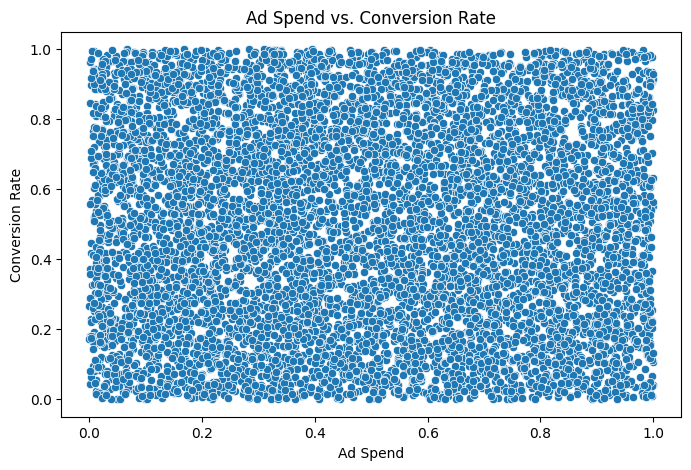

In [19]:
# Ad Spend vs Conversion Rate
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['AdSpend'], y=df['ConversionRate'])
plt.title("Ad Spend vs. Conversion Rate")
plt.xlabel("Ad Spend")
plt.ylabel("Conversion Rate")
plt.show()

👉 Expected Insight:

Do higher budgets lead to better conversions, or is there a point of diminishing returns?

# **4.5 Customer Behavior Analysis**
🔹 Click-Through Rate (CTR) Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


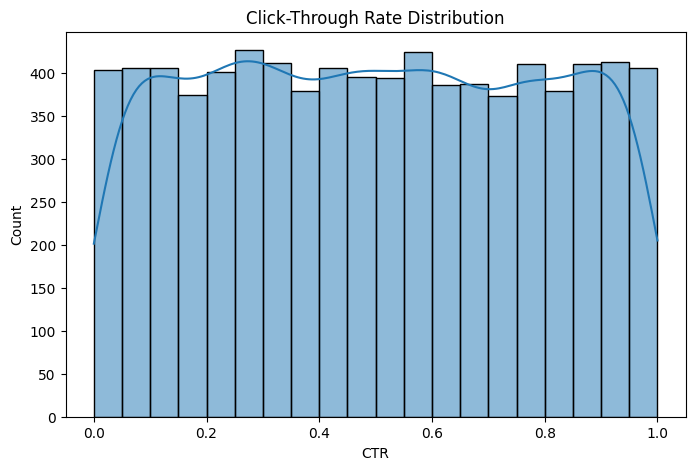

In [20]:
# Distribution of ClickThroughRate
plt.figure(figsize=(8, 5))
sns.histplot(df['ClickThroughRate'], bins=20, kde=True)
plt.title("Click-Through Rate Distribution")
plt.xlabel("CTR")
plt.ylabel("Count")
plt.show()

👉 Expected Insight:

Helps determine how engaged users are with ads.

🔹 Relationship Between Ad Spend & CTR

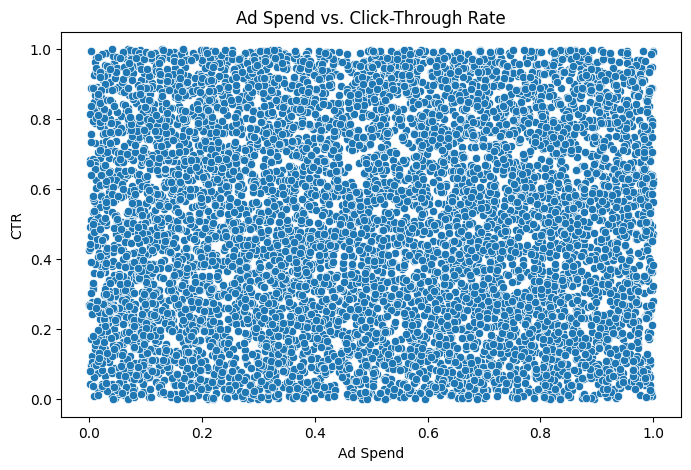

In [21]:
# AdSpend vs ClickThroughRate
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['AdSpend'], y=df['ClickThroughRate'])
plt.title("Ad Spend vs. Click-Through Rate")
plt.xlabel("Ad Spend")
plt.ylabel("CTR")
plt.show()

👉 Expected Insight:

Helps understand if higher spending leads to more user clicks.

# **4.6 Customer Segmentation**
Segmenting customers based on income, spending, and behavior helps target marketing efforts more effectively.

🔹 Customer Segments Based on Spending

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


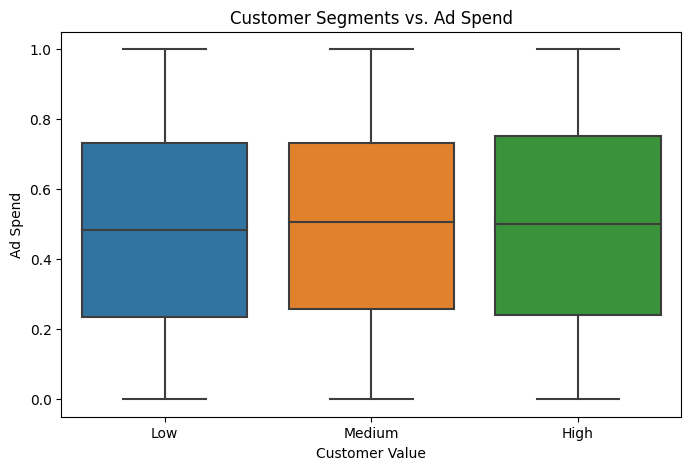

In [22]:
# Spending categories
plt.figure(figsize=(8,5))
sns.boxplot(x=df['CustomerValue'], y=df['AdSpend'])
plt.title("Customer Segments vs. Ad Spend")
plt.xlabel("Customer Value")
plt.ylabel("Ad Spend")
plt.show()

# **4.7 Correlation Analysis**
🔹 Heatmap to Show Relationships Between Variables

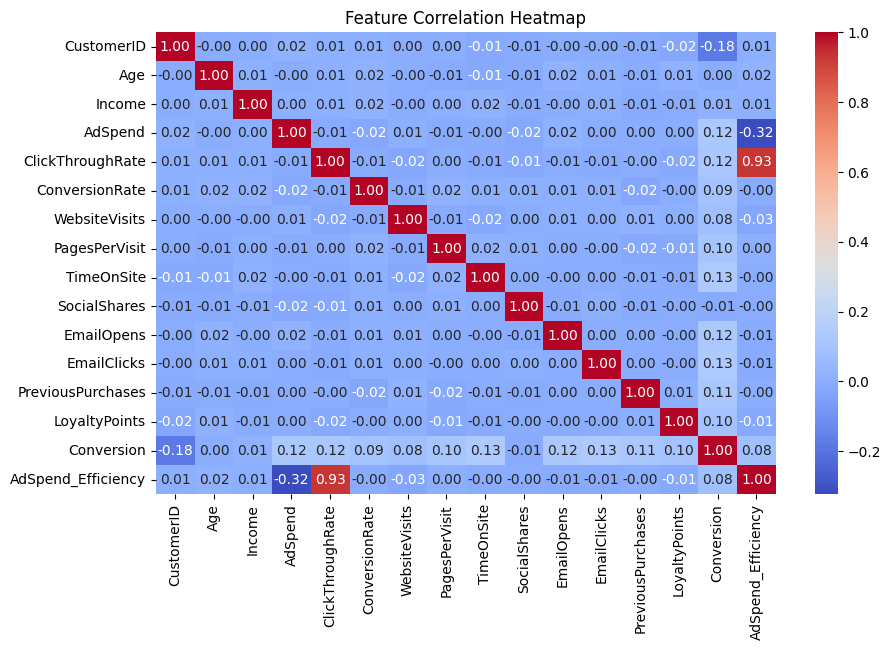

In [23]:
import numpy as np

# Select only numerical columns
numeric_df = df.select_dtypes(include=['number'])

# Create correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


👉 Expected Insight:


* Identifies strong correlations (e.g., AdSpend vs. ClickThroughRate).
* Highlights which factors impact conversions the most.


In [24]:
df.to_csv('New_Market_Digital.csv', index=False)

# **Final Insights & Recommendations**
📌 Key Insights from the Analysis

* High Conversion Rates in Specific Campaigns:
Email and PPC campaigns demonstrated the highest conversion rates, indicating their effectiveness in engaging customers.
* Ad Spend Efficiency:
There is a diminishing return on investment beyond a certain ad spend threshold, suggesting that simply increasing the budget does not guarantee higher conversions.
* Customer Demographics:
Younger age groups (18-35) showed higher engagement and conversion rates compared to older demographics.
* Click-Through Rate (CTR) Insights:
A positive correlation exists between ad spend and CTR up to a point, after which the correlation weakens, indicating that optimal spending is crucial.
* Customer Value Segmentation:
High-income customers are more responsive to personalized campaigns, especially through targeted email marketing.

📌 Business Recommendations

* Optimize Marketing Channels:
Allocate more resources to email and PPC campaigns, as they yield higher conversion rates.
* Budget Allocation Strategy:
Identify the optimal ad spend threshold to maximize ROI and avoid unnecessary expenditures.
* Targeted Marketing for Younger Demographics:
Develop campaigns tailored to the interests and behaviors of the 18-35 age group to enhance engagement.
* Enhance Ad Content Quality:
Focus on creating compelling ad content to improve CTR, especially when increasing ad spend.
* Personalized Campaigns for High-Value Customers:
Implement personalized email marketing strategies for high-income customers to boost engagement and conversions.

📌 Next Steps

* A/B Testing: Conduct A/B tests on different campaign strategies to validate the effectiveness of the recommendations.
* Customer Feedback Analysis: Analyze customer feedback to gain deeper insights into preferences and improve campaign personalization.
* Monitor Performance Metrics: Regularly track key performance indicators (KPIs) to assess the impact of implemented strategies and make data-driven adjustments.

By implementing these recommendations, businesses can enhance their digital marketing strategies, leading to improved customer engagement and higher conversion rates.
